<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/zindi_airstrip_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio
!pip -q install torch
!pip -q install torchvision
!pip -q install albumentations
!pip -q install segmentation-models-pytorch
!pip -q install tqdm

In [2]:
import os
import torch
import rasterio
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Download training data to local compute node

## Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress training files, copy over and uncompress

In [22]:
# Navigate to the shared directory
%cd /content/drive/MyDrive/Zindi-Amazon/training
# Zip the data
!zip -r /content/images.zip images
!zip -r /content/masks.zip masks
!zip -r /content/masks_10m.zip masks_10m
!zip -r /content/masks_20m.zip masks_20m
!zip -r /content/masks_100m.zip masks_100m
!zip -r /content/masks_200m.zip masks_200m
# Unzip the files
!unzip /content/images.zip -d /content
!unzip /content/masks.zip -d /content
!unzip /content/masks_10m.zip -d /content
!unzip /content/masks_20m.zip -d /content
!unzip /content/masks_100m.zip -d /content
!unzip /content/masks_200m.zip -d /content

/content/drive/.shortcut-targets-by-id/14mw0v8Bi-MzhsqSI0K3KO23YrUHttM7P/Zindi-Amazon/training
  adding: images/ (stored 0%)
  adding: images/Sentinel_AllBands_Training_Id_59.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_61.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_78.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_79.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_105.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_120.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_135.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_176.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_157.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_148.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_17.tif (deflated 4%)
  adding: images/Sentinel_AllBands_Training_Id_99.tif (deflated 5%)
  adding: images/Sentinel_AllBands_Training_Id_172.ti

# Custom classes and functions to handle Sentinel 1/2 data and corresponding masks

In [23]:
# Custom Dataset class for Sentinel 1/2 bands and mask
class Sentinel2Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask using rasterio
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            # Extract band indexes from descriptions and read directly
            bands = {'B4': None, 'B3': None, 'B2': None}
            for i, desc in enumerate(src.descriptions):
                if desc in bands:
                    bands[desc] = src.read(i + 1)  # Read 1-based bands

            # Check if all required bands were found
            if any(value is None for value in bands.values()):
                raise ValueError(f"Not all bands found in image: {image_path}")

            # Stack the selected bands to form the final image array
            #image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
            image = np.stack([np.clip(bands['B4'],0,2000)/2000,
                              np.clip(bands['B3'],0,2000)/2000,
                              np.clip(bands['B2'],0,2000)/2000], axis=-1)

        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)

        # Ensure both image and mask are numpy arrays before applying transforms
        image = np.array(image)
        mask = np.array(mask)

        if check_for_nan_inf(image) or check_for_nan_inf(mask):
            raise ValueError(f"NaN or Inf values found in data: {image_path}, {mask_path}")



        # Convert image and mask to PyTorch tensors
        #image = torch.from_numpy(image).type(torch.float32)  # Assuming image is a NumPy array
        #mask = torch.from_numpy(mask).type(torch.float32)   # Assuming mask is a NumPy array

        # Continue with your transformations and other logic:
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Only convert to PyTorch tensors if not already tensors (skip if the transform does it)
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # Channels first
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask


In [24]:
def check_for_nan_inf(data):
    """Checks for NaN or Inf values in NumPy data."""
    if np.isnan(data).any() or np.isinf(data).any():
        return True  # Found NaN or Inf
    else:
        return False  # No NaN or Inf


In [25]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='train'):
    if option == 'train':
        return A.Compose([
            #A.RandomCrop(width=224, height=224),
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
            #A.Resize(width=224, height=224),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    elif option == 'val':
        return A.Compose([
            #A.RandomCrop(height=224, width=224),  # Resize for validation
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    elif option == 'test':
        return A.Compose([
            #A.RandomCrop(height=224, width=224),  # Resize for testing
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
            ToTensorV2(),
        ], additional_targets={'mask': 'mask'})
    else:
        raise ValueError("Invalid option. Choose from 'train', 'val', or 'test'.")

In [26]:
# UNet model with ResNet50 encoder
def get_model():
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=3,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [27]:
# Training loop
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    running_loss = 0.0
    running_total_pixels = 0.0
    running_correct_pixels = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Change data type of masks to float32 before moving to device
        masks = masks.type(torch.float32).to(device).unsqueeze(1)  # Add channel dimension to masks
        images = images.float()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        ## Next line is an attempt at limiting loss from exploding.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to a maximum norm of 1
        optimizer.step()

        # Calculate per-pixel accuracy
        preds = torch.sigmoid(outputs) > 0.5  # Threshold to convert logits to binary predictions (for binary segmentation)
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()  # Total number of pixels in the batch

        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy

In [28]:
def evaluate(model, dataloader, criterion, device, phase="val", plot=False):
    model.eval()

    running_loss = 0
    running_correct_pixels = 0
    total_iou = 0
    num_samples = 0
    running_total_pixels = 0

    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


    for i, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        masks = masks.to(device)

        # Add channel dimension to the target masks
        masks = masks.type(torch.float32)
        masks = masks.unsqueeze(1)


        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, masks)
            # Apply sigmoid to the outputs (for binary segmentation) and threshold
            preds = torch.sigmoid(outputs) > 0.5

        # Calculate per-pixel accuracy
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

        # Calculate IoU for each sample in the batch
        for j in range(images.shape[0]):
            #prediction = outputs[j]
            #prediction = torch.sigmoid(prediction)
            prediction = preds[j].squeeze(0)  # Remove channel dimension
            #prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5
            prediction = (prediction > 0.5).float()  # Example threshold of 0.5
            iou = calculate_jaccard_index(prediction, masks[j])
            total_iou += iou
            num_samples += 1


        if plot:
            # Plot image, mask, and prediction for a sample in the batch
            for i in range(images.shape[0]):  # Loop through batch
                image = images[i].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
                image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
                mask = masks[i].cpu().squeeze().numpy()
                prediction = outputs[i].cpu().squeeze()

                # Apply sigmoid for binary segmentation if your model output is logits.
                prediction = torch.sigmoid(prediction)

                # Threshold predictions (adjust threshold as needed)
                prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

                plot_predictions(image, mask, prediction) # Call plot function

        running_loss += loss.item() * images.size(0)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    average_iou = total_iou / num_samples

    print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
    print(f"Average Jaccard Index (IoU): {average_iou:.4f}")

    return epoch_loss, epoch_accuracy, average_iou  # Return the average validation loss

In [29]:
def fit(model, train_loader, val_loader, n_epochs, criterion, optimizer, device):
    # Keep track of the best loss and
    # best model weights with the lowest loss

    best_loss = np.inf # Initialize with a very high value
    best_model = model.state_dict() # Initialize with the initial model state

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    val_jaccard = []


    # Train and test over n_epochs
    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch+1))
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        val_loss, val_acc, val_jac = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        val_jaccard.append(val_jac)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model)

    # Plotting the loss curves
    # Plotting the training curves
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # 3 subplots for Loss, Accuracy, Jaccard

    # Loss subplot
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(train_accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Jaccard subplot
    axes[2].plot(val_jaccard, label='Validation Jaccard')
    axes[2].set_title('Jaccard Index')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Jaccard Index')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


    return model

In [30]:
def plot_predictions(image, mask, prediction):
    """Plots the image, mask, and prediction side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Mask")
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title("Prediction")
    plt.show()


In [31]:
def calculate_jaccard_index(y_pred, y_true, smooth=1e-6):
    """Calculates the Jaccard index (IoU) between predictions and targets."""

    # Check if inputs are NumPy arrays and convert if necessary
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.from_numpy(y_pred)
    if isinstance(y_true, np.ndarray):  # Check if y_true is a NumPy array before converting
        y_true = torch.from_numpy(y_true)

    # Flatten predictions and targets using torch.flatten
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # Calculate intersection and union
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # Check if iou is a single-element tensor before calling .item()
    if iou.dim() == 0:
        return iou.item()  # Return as a single number
    else:
        return iou  # Return the tensor as is if it has multiple elements

In [32]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss)

In [33]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * torch.sum(probs * targets, dim=(2,3)) + self.smooth
        den = torch.sum(probs + targets, dim=(2,3)) + self.smooth
        dice = num / den
        return 1 - dice.mean()

In [34]:
# Combined BCEWithLogitsLoss and DiceLoss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [35]:
class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Flatten predictions and targets
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # Calculate intersection and union
        intersection = (y_pred * y_true).sum()
        union = (y_pred + y_true).sum()

        # Jaccard similarity (IoU)
        iou = (intersection + self.smooth) / (union - intersection + self.smooth)

        # Jaccard loss (1 - IoU)
        loss = 1 - iou

        return loss

# Google Colab GPU
Check that the GPU enabled in your colab notebook by running the cell below.

In [36]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


# Main loop

In [70]:
image_dir = '/content/images'
mask_dir = '/content/masks_200m'

# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

## Split into Train, Validation, and Test Sets

In [71]:
# Create dataset and dataloader

# Apply different transformations to the training, val, and test sets
train_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='train'))
val_data = Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='val'))
test_data =  Sentinel2Dataset(image_paths=image_paths, mask_paths=mask_paths, transform=get_augmentations(option='test'))

# Randomly split the dataset into 80% train / 10% val / 10% test
# by subsetting the transformed train and test datasets
train_size = 0.80
val_size = 0.10
indices = list(range(int(len(train_data))))
train_split = int(train_size * len(train_data))
val_split = int(val_size * len(val_data))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 86/10/12


## Create a data loaders

In [72]:
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Visualize the data

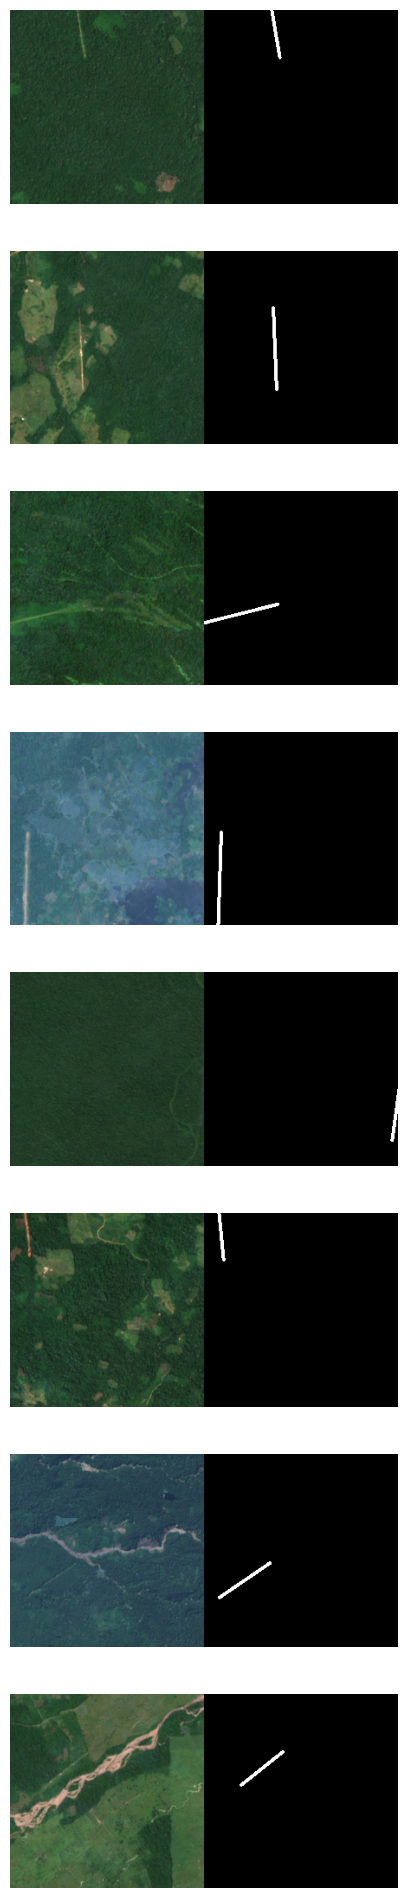

In [31]:
# You do not have to run this cell, It simply forces one iteration of the
# data loader (training) and plot the returned images and corresponding masks
# after image augmentation. This is a nice sanity check to make sure the mask
# and image still match...

imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


images, masks = next(iter(train_loader))
fig, axes = plt.subplots(8, 2, figsize=(5, 25))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(8):
    image = images[i].permute(1, 2, 0).numpy()
    mask = masks[i].squeeze().numpy()

    #R_layer = image[:, :, 0]
    #G_layer = image[:, :, 1]
    #B_layer = image[:, :, 2]
    #print(f'R stats:  min:{R_layer.min()}, max:{R_layer.max()}, mean:{R_layer.mean()}, std:{R_layer.std()}')
    #print(f'G stats:  min:{G_layer.min()}, max:{G_layer.max()}, mean:{G_layer.mean()}, std:{G_layer.std()}')
    #print(f'B stats:  min:{B_layer.min()}, max:{B_layer.max()}, mean:{B_layer.mean()}, std:{B_layer.std()}')
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')
plt.show()


## Instantiate the model

In [73]:
try:
    del model  # Try to delete the model
except NameError:
    pass  # If the model isn't defined, do nothing

In [74]:
model = get_model().to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

Specify the criterion, optimizer, and hyperparameters (e.g.

1.   Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2.   Train the model on the training set by updating its weights to minimize the loss function.
3.    Evaluate the model on the test set to observe performance on new, unseen data.
4.    Repeat steps 2 and 3 n_epochs times.

In [75]:
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([500], dtype=torch.float32).to(device))  # Binary cross-entropy loss
#criterion = FocalLoss(alpha=1, gamma=2)
criterion = DiceLoss()
#criterion = BCEDiceLoss()
#criterion = JaccardLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 100




We can now commence model training and evaluation in the following cell.

Epoch 1


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train Loss: 0.82; Accuracy: 44.71


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Val Loss: 0.82; Accuracy: 51.44
Average Jaccard Index (IoU): 0.1159
Epoch 2


100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


Train Loss: 0.77; Accuracy: 55.93


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.73; Accuracy: 57.79
Average Jaccard Index (IoU): 0.1804
Epoch 3


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.75; Accuracy: 59.83


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.70; Accuracy: 67.26
Average Jaccard Index (IoU): 0.2299
Epoch 4


100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Train Loss: 0.73; Accuracy: 65.45


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.75; Accuracy: 48.22
Average Jaccard Index (IoU): 0.1730
Epoch 5


100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


Train Loss: 0.69; Accuracy: 68.31


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.66; Accuracy: 77.94
Average Jaccard Index (IoU): 0.3437
Epoch 6


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.67; Accuracy: 69.52


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Val Loss: 0.53; Accuracy: 84.28
Average Jaccard Index (IoU): 0.4363
Epoch 7


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.65; Accuracy: 78.28


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Val Loss: 0.60; Accuracy: 90.52
Average Jaccard Index (IoU): 0.4257
Epoch 8


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.57; Accuracy: 80.13


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.59; Accuracy: 91.16
Average Jaccard Index (IoU): 0.4138
Epoch 9


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Train Loss: 0.61; Accuracy: 81.63


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.75; Accuracy: 61.73
Average Jaccard Index (IoU): 0.1566
Epoch 10


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.57; Accuracy: 83.75


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Val Loss: 0.54; Accuracy: 90.61
Average Jaccard Index (IoU): 0.3710
Epoch 11


100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


Train Loss: 0.54; Accuracy: 84.51


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Val Loss: 0.66; Accuracy: 79.56
Average Jaccard Index (IoU): 0.2427
Epoch 12


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train Loss: 0.59; Accuracy: 86.41


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.57; Accuracy: 85.01
Average Jaccard Index (IoU): 0.3456
Epoch 13


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train Loss: 0.60; Accuracy: 83.78


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Val Loss: 0.65; Accuracy: 82.32
Average Jaccard Index (IoU): 0.2617
Epoch 14


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.59; Accuracy: 85.48


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.38; Accuracy: 91.83
Average Jaccard Index (IoU): 0.5356
Epoch 15


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.55; Accuracy: 86.50


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.50; Accuracy: 93.79
Average Jaccard Index (IoU): 0.4327
Epoch 16


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.58; Accuracy: 87.97


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.65; Accuracy: 83.77
Average Jaccard Index (IoU): 0.2648
Epoch 17


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.55; Accuracy: 88.47


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Val Loss: 0.53; Accuracy: 87.31
Average Jaccard Index (IoU): 0.4372
Epoch 18


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train Loss: 0.48; Accuracy: 89.60


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.59; Accuracy: 91.52
Average Jaccard Index (IoU): 0.3426
Epoch 19


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train Loss: 0.52; Accuracy: 89.68


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Val Loss: 0.40; Accuracy: 92.63
Average Jaccard Index (IoU): 0.5204
Epoch 20


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Loss: 0.49; Accuracy: 90.06


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.46; Accuracy: 93.57
Average Jaccard Index (IoU): 0.4942
Epoch 21


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.48; Accuracy: 91.79


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.42; Accuracy: 93.79
Average Jaccard Index (IoU): 0.5336
Epoch 22


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.51; Accuracy: 91.20


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.56; Accuracy: 90.97
Average Jaccard Index (IoU): 0.3686
Epoch 23


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Loss: 0.46; Accuracy: 91.90


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Val Loss: 0.48; Accuracy: 93.51
Average Jaccard Index (IoU): 0.4565
Epoch 24


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train Loss: 0.46; Accuracy: 93.17


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.50; Accuracy: 90.19
Average Jaccard Index (IoU): 0.4118
Epoch 25


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train Loss: 0.47; Accuracy: 93.23


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Val Loss: 0.46; Accuracy: 94.38
Average Jaccard Index (IoU): 0.4840
Epoch 26


100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


Train Loss: 0.45; Accuracy: 92.95


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.32; Accuracy: 95.40
Average Jaccard Index (IoU): 0.6114
Epoch 27


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.43; Accuracy: 92.20


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.49; Accuracy: 91.83
Average Jaccard Index (IoU): 0.4160
Epoch 28


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.43; Accuracy: 92.67


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.44; Accuracy: 94.81
Average Jaccard Index (IoU): 0.4835
Epoch 29


100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Train Loss: 0.40; Accuracy: 92.07


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Val Loss: 0.50; Accuracy: 94.41
Average Jaccard Index (IoU): 0.4363
Epoch 30


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.40; Accuracy: 94.04


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.70; Accuracy: 74.12
Average Jaccard Index (IoU): 0.2277
Epoch 31


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.44; Accuracy: 94.70


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Val Loss: 0.47; Accuracy: 96.54
Average Jaccard Index (IoU): 0.4822
Epoch 32


100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


Train Loss: 0.40; Accuracy: 94.65


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.39; Accuracy: 95.74
Average Jaccard Index (IoU): 0.4988
Epoch 33


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.39; Accuracy: 93.46


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Val Loss: 0.24; Accuracy: 97.42
Average Jaccard Index (IoU): 0.6947
Epoch 34


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.39; Accuracy: 94.38


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.63; Accuracy: 95.31
Average Jaccard Index (IoU): 0.3022
Epoch 35


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.35; Accuracy: 95.13


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Val Loss: 0.47; Accuracy: 94.53
Average Jaccard Index (IoU): 0.4328
Epoch 36


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.35; Accuracy: 94.95


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.26; Accuracy: 96.09
Average Jaccard Index (IoU): 0.6616
Epoch 37


100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


Train Loss: 0.40; Accuracy: 94.64


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Val Loss: 0.32; Accuracy: 96.38
Average Jaccard Index (IoU): 0.6273
Epoch 38


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.34; Accuracy: 95.08


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.54; Accuracy: 92.78
Average Jaccard Index (IoU): 0.3637
Epoch 39


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.39; Accuracy: 94.43


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.22; Accuracy: 96.70
Average Jaccard Index (IoU): 0.6814
Epoch 40


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.32; Accuracy: 95.49


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.54; Accuracy: 93.22
Average Jaccard Index (IoU): 0.3789
Epoch 41


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.34; Accuracy: 94.17


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.47; Accuracy: 93.88
Average Jaccard Index (IoU): 0.4495
Epoch 42


100%|██████████| 11/11 [00:10<00:00,  1.05it/s]


Train Loss: 0.40; Accuracy: 95.11


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Val Loss: 0.39; Accuracy: 94.34
Average Jaccard Index (IoU): 0.5178
Epoch 43


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.39; Accuracy: 94.82


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Val Loss: 0.24; Accuracy: 95.01
Average Jaccard Index (IoU): 0.6414
Epoch 44


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Loss: 0.39; Accuracy: 94.36


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.50; Accuracy: 96.48
Average Jaccard Index (IoU): 0.4331
Epoch 45


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Train Loss: 0.36; Accuracy: 93.57


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.34; Accuracy: 94.07
Average Jaccard Index (IoU): 0.5469
Epoch 46


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.38; Accuracy: 93.95


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.24; Accuracy: 96.16
Average Jaccard Index (IoU): 0.6920
Epoch 47


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.36; Accuracy: 95.13


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.19; Accuracy: 96.95
Average Jaccard Index (IoU): 0.7011
Epoch 48


100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


Train Loss: 0.30; Accuracy: 95.47


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.45; Accuracy: 94.93
Average Jaccard Index (IoU): 0.4603
Epoch 49


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train Loss: 0.36; Accuracy: 94.40


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Val Loss: 0.29; Accuracy: 95.26
Average Jaccard Index (IoU): 0.6234
Epoch 50


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.33; Accuracy: 95.20


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.46; Accuracy: 94.25
Average Jaccard Index (IoU): 0.4608
Epoch 51


100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


Train Loss: 0.42; Accuracy: 94.31


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.65; Accuracy: 87.49
Average Jaccard Index (IoU): 0.2678
Epoch 52


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.35; Accuracy: 94.08


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.43; Accuracy: 91.60
Average Jaccard Index (IoU): 0.4530
Epoch 53


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.34; Accuracy: 94.39


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.35; Accuracy: 93.77
Average Jaccard Index (IoU): 0.5644
Epoch 54


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.34; Accuracy: 95.45


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Val Loss: 0.38; Accuracy: 95.83
Average Jaccard Index (IoU): 0.5505
Epoch 55


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.34; Accuracy: 95.77


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Val Loss: 0.42; Accuracy: 96.32
Average Jaccard Index (IoU): 0.4999
Epoch 56


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.39; Accuracy: 95.35


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Val Loss: 0.32; Accuracy: 96.69
Average Jaccard Index (IoU): 0.6073
Epoch 57


100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Train Loss: 0.39; Accuracy: 95.17


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.40; Accuracy: 93.65
Average Jaccard Index (IoU): 0.5198
Epoch 58


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.28; Accuracy: 95.81


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.39; Accuracy: 94.93
Average Jaccard Index (IoU): 0.5231
Epoch 59


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.39; Accuracy: 95.15


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.30; Accuracy: 94.65
Average Jaccard Index (IoU): 0.6143
Epoch 60


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.36; Accuracy: 95.86


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.58; Accuracy: 95.59
Average Jaccard Index (IoU): 0.3725
Epoch 61


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


Train Loss: 0.39; Accuracy: 95.17


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Val Loss: 0.45; Accuracy: 94.06
Average Jaccard Index (IoU): 0.4484
Epoch 62


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train Loss: 0.33; Accuracy: 95.40


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Val Loss: 0.34; Accuracy: 96.27
Average Jaccard Index (IoU): 0.5734
Epoch 63


100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


Train Loss: 0.32; Accuracy: 94.02


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.33; Accuracy: 94.20
Average Jaccard Index (IoU): 0.5949
Epoch 64


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.33; Accuracy: 95.44


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.39; Accuracy: 96.60
Average Jaccard Index (IoU): 0.5561
Epoch 65


100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


Train Loss: 0.35; Accuracy: 95.75


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Val Loss: 0.36; Accuracy: 92.34
Average Jaccard Index (IoU): 0.5209
Epoch 66


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.30; Accuracy: 96.63


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.52; Accuracy: 93.07
Average Jaccard Index (IoU): 0.3868
Epoch 67


100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


Train Loss: 0.36; Accuracy: 95.24


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Val Loss: 0.50; Accuracy: 95.60
Average Jaccard Index (IoU): 0.4361
Epoch 68


100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


Train Loss: 0.30; Accuracy: 95.18


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Val Loss: 0.30; Accuracy: 95.64
Average Jaccard Index (IoU): 0.5880
Epoch 69


100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


Train Loss: 0.31; Accuracy: 95.73


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Val Loss: 0.34; Accuracy: 95.16
Average Jaccard Index (IoU): 0.5763
Epoch 70


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.32; Accuracy: 95.68


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.32; Accuracy: 96.95
Average Jaccard Index (IoU): 0.6039
Epoch 71


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Train Loss: 0.34; Accuracy: 95.77


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Val Loss: 0.34; Accuracy: 95.94
Average Jaccard Index (IoU): 0.5560
Epoch 72


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.37; Accuracy: 95.46


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.66; Accuracy: 94.78
Average Jaccard Index (IoU): 0.2705
Epoch 73


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.31; Accuracy: 96.38


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.17; Accuracy: 96.30
Average Jaccard Index (IoU): 0.7488
Epoch 74


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.32; Accuracy: 95.98


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Val Loss: 0.45; Accuracy: 93.88
Average Jaccard Index (IoU): 0.4567
Epoch 75


100%|██████████| 11/11 [00:09<00:00,  1.12it/s]


Train Loss: 0.32; Accuracy: 96.49


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Val Loss: 0.55; Accuracy: 92.88
Average Jaccard Index (IoU): 0.3698
Epoch 76


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.34; Accuracy: 95.98


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.46; Accuracy: 97.17
Average Jaccard Index (IoU): 0.4804
Epoch 77


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


Train Loss: 0.34; Accuracy: 95.79


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.41; Accuracy: 94.91
Average Jaccard Index (IoU): 0.5296
Epoch 78


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.37; Accuracy: 95.08


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.54; Accuracy: 95.65
Average Jaccard Index (IoU): 0.3954
Epoch 79


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


Train Loss: 0.38; Accuracy: 95.81


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Val Loss: 0.67; Accuracy: 93.36
Average Jaccard Index (IoU): 0.2542
Epoch 80


100%|██████████| 11/11 [00:10<00:00,  1.09it/s]


Train Loss: 0.36; Accuracy: 95.94


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Val Loss: 0.44; Accuracy: 95.08
Average Jaccard Index (IoU): 0.4887
Epoch 81


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.32; Accuracy: 95.61


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Val Loss: 0.41; Accuracy: 94.53
Average Jaccard Index (IoU): 0.4965
Epoch 82


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.32; Accuracy: 96.01


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.38; Accuracy: 97.20
Average Jaccard Index (IoU): 0.5365
Epoch 83


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.31; Accuracy: 96.62


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.51; Accuracy: 94.50
Average Jaccard Index (IoU): 0.4172
Epoch 84


100%|██████████| 11/11 [00:12<00:00,  1.09s/it]


Train Loss: 0.38; Accuracy: 96.20


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.46; Accuracy: 97.02
Average Jaccard Index (IoU): 0.5002
Epoch 85


100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


Train Loss: 0.31; Accuracy: 95.77


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.37; Accuracy: 96.92
Average Jaccard Index (IoU): 0.5464
Epoch 86


100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


Train Loss: 0.30; Accuracy: 95.54


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Val Loss: 0.17; Accuracy: 97.99
Average Jaccard Index (IoU): 0.7440
Epoch 87


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.27; Accuracy: 95.50


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Val Loss: 0.40; Accuracy: 95.15
Average Jaccard Index (IoU): 0.5467
Epoch 88


100%|██████████| 11/11 [00:11<00:00,  1.03s/it]


Train Loss: 0.31; Accuracy: 96.86


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.55; Accuracy: 95.00
Average Jaccard Index (IoU): 0.3845
Epoch 89


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.32; Accuracy: 96.52


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Val Loss: 0.78; Accuracy: 94.84
Average Jaccard Index (IoU): 0.1938
Epoch 90


100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


Train Loss: 0.34; Accuracy: 96.10


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Val Loss: 0.40; Accuracy: 94.07
Average Jaccard Index (IoU): 0.5014
Epoch 91


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.32; Accuracy: 95.90


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.29; Accuracy: 94.55
Average Jaccard Index (IoU): 0.6246
Epoch 92


100%|██████████| 11/11 [00:10<00:00,  1.03it/s]


Train Loss: 0.27; Accuracy: 96.53


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Val Loss: 0.62; Accuracy: 91.14
Average Jaccard Index (IoU): 0.2889
Epoch 93


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


Train Loss: 0.29; Accuracy: 96.81


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


Val Loss: 0.40; Accuracy: 96.27
Average Jaccard Index (IoU): 0.5270
Epoch 94


100%|██████████| 11/11 [00:10<00:00,  1.01it/s]


Train Loss: 0.35; Accuracy: 96.88


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Val Loss: 0.40; Accuracy: 96.56
Average Jaccard Index (IoU): 0.5334
Epoch 95


100%|██████████| 11/11 [00:11<00:00,  1.08s/it]


Train Loss: 0.29; Accuracy: 95.45


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Val Loss: 0.34; Accuracy: 94.60
Average Jaccard Index (IoU): 0.5718
Epoch 96


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.33; Accuracy: 95.25


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Val Loss: 0.40; Accuracy: 95.55
Average Jaccard Index (IoU): 0.5086
Epoch 97


100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


Train Loss: 0.31; Accuracy: 96.02


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Val Loss: 0.43; Accuracy: 94.86
Average Jaccard Index (IoU): 0.4878
Epoch 98


100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


Train Loss: 0.31; Accuracy: 95.48


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Val Loss: 0.36; Accuracy: 95.35
Average Jaccard Index (IoU): 0.5419
Epoch 99


100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


Train Loss: 0.27; Accuracy: 95.84


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


Val Loss: 0.39; Accuracy: 95.03
Average Jaccard Index (IoU): 0.5259
Epoch 100


100%|██████████| 11/11 [00:09<00:00,  1.10it/s]


Train Loss: 0.31; Accuracy: 96.57


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Val Loss: 0.51; Accuracy: 93.81
Average Jaccard Index (IoU): 0.4021


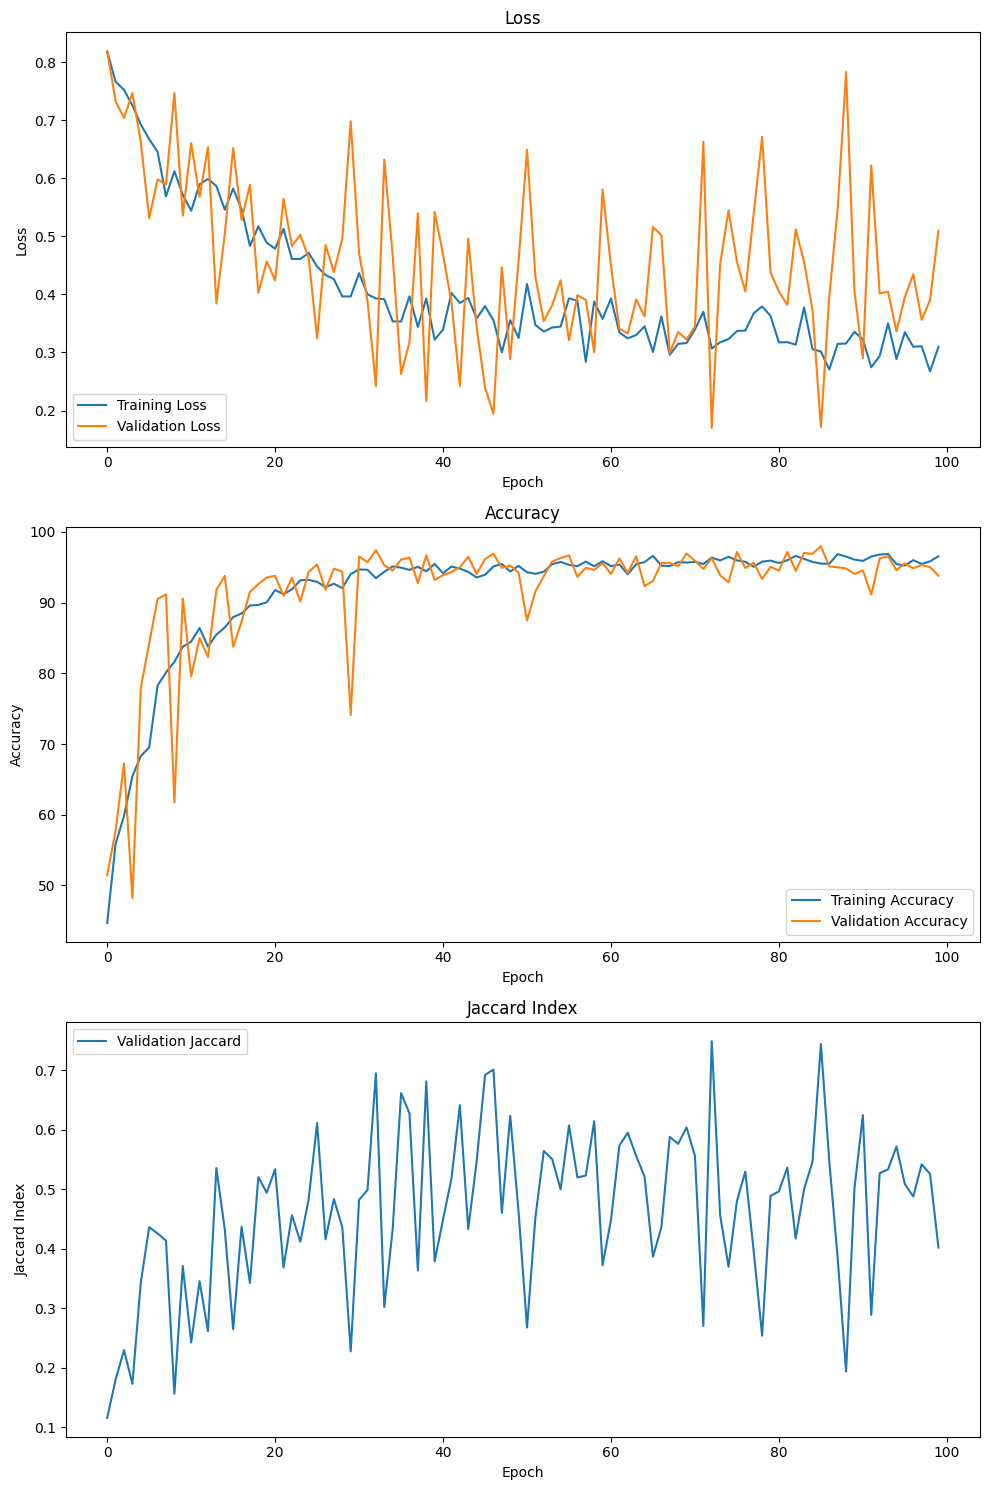

In [76]:
best_model = fit(model, train_loader, val_loader, epochs, criterion=criterion, optimizer=optimizer, device=device)

# Training loop
#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


## Model Performance on the Test Set

Using the best model from the previous steps, we can evaluate the model performance on the test set.

  0%|          | 0/2 [00:00<?, ?it/s]

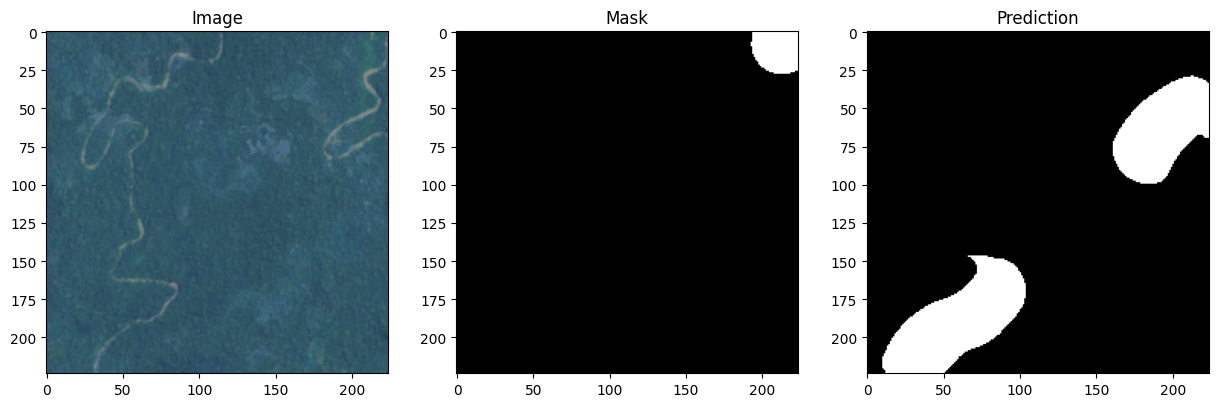

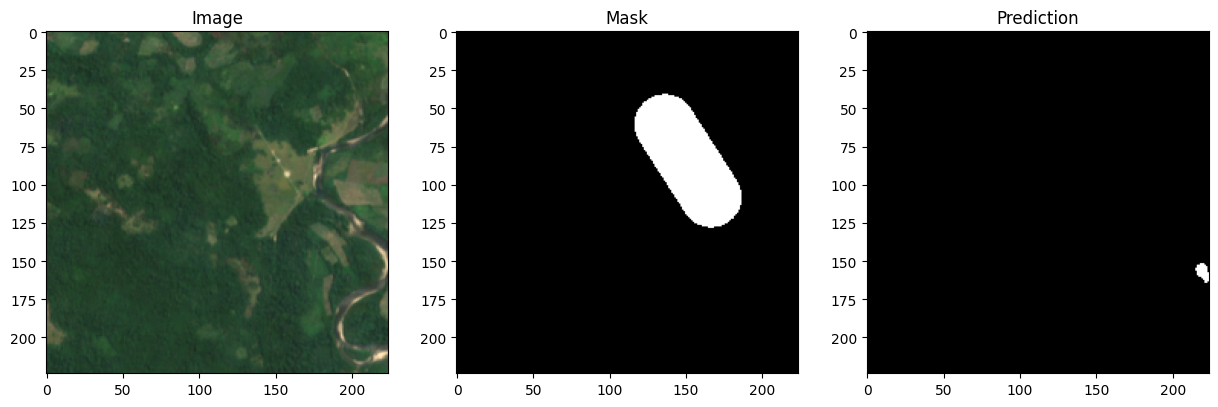

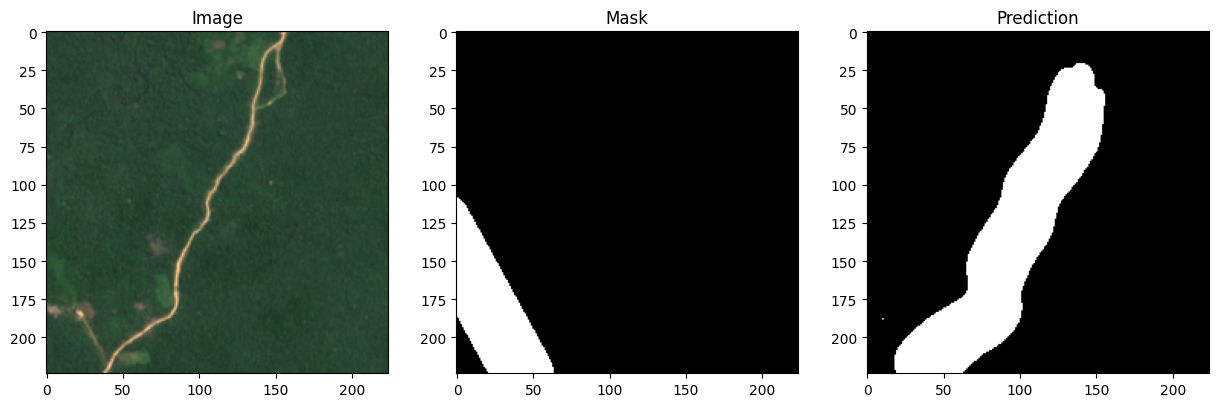

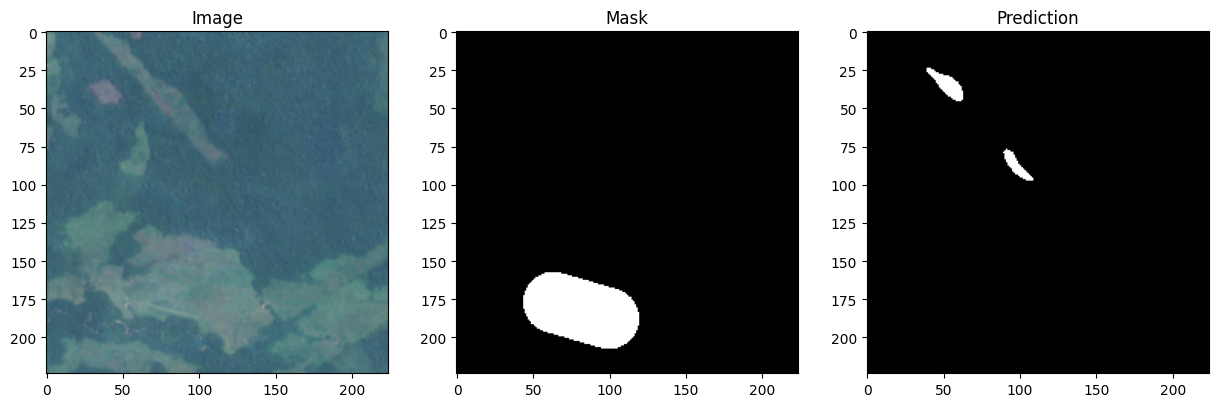

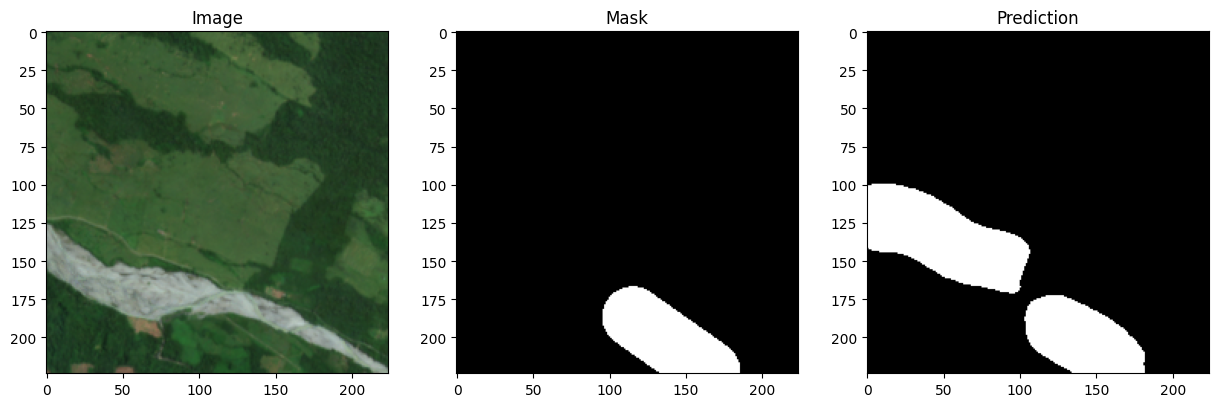

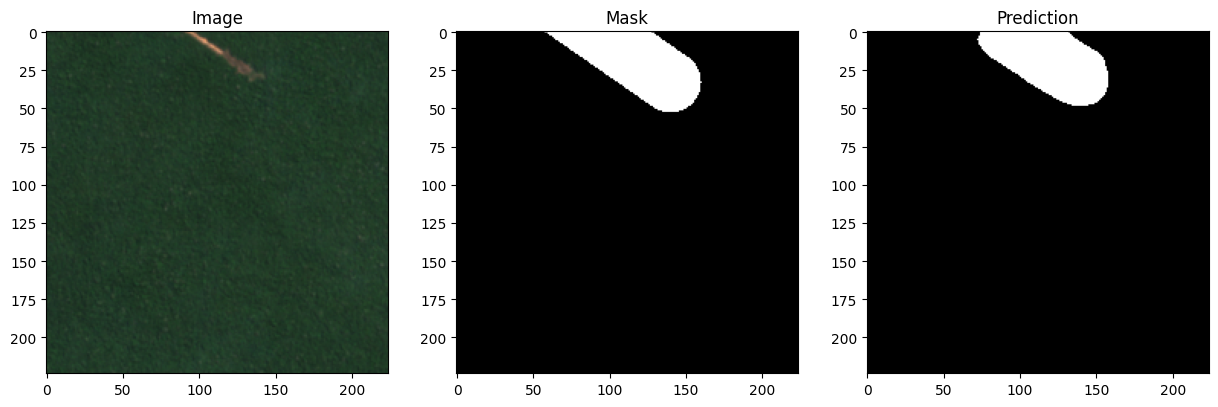

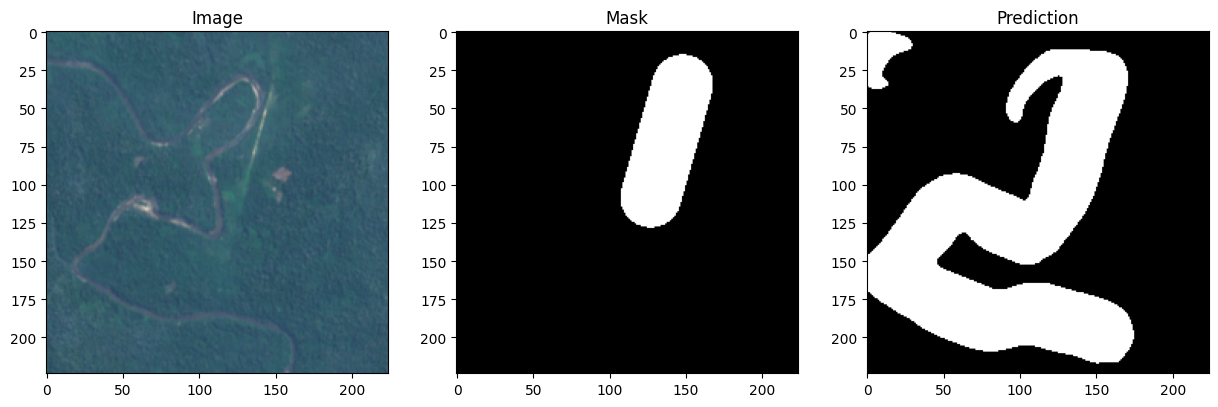

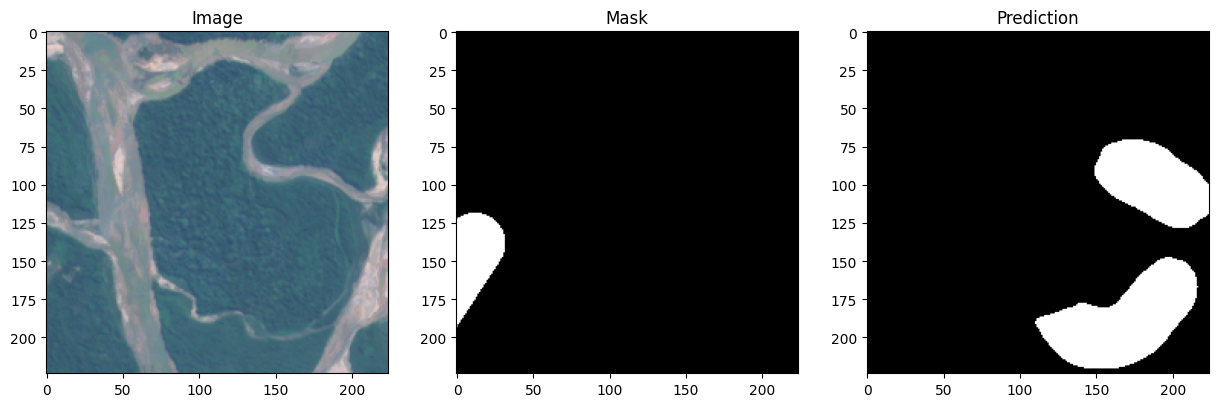

 50%|█████     | 1/2 [00:06<00:06,  6.88s/it]

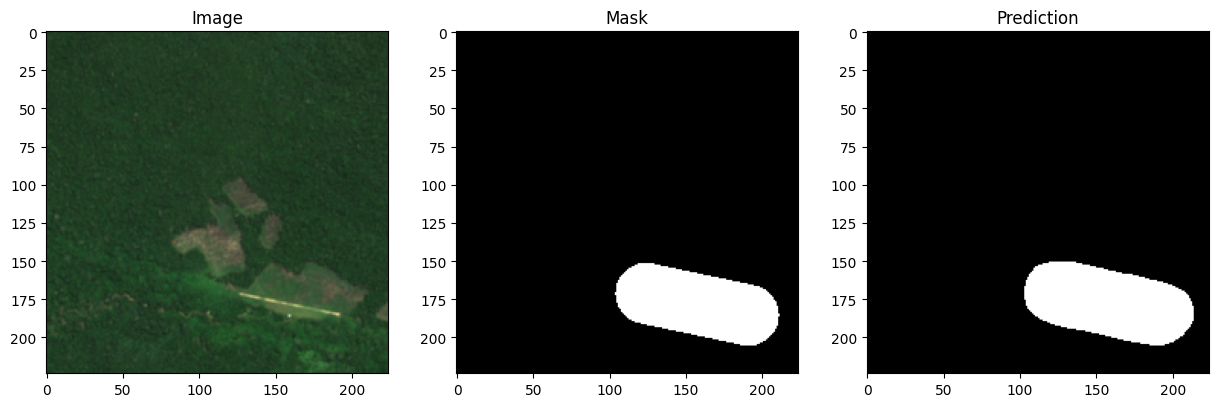

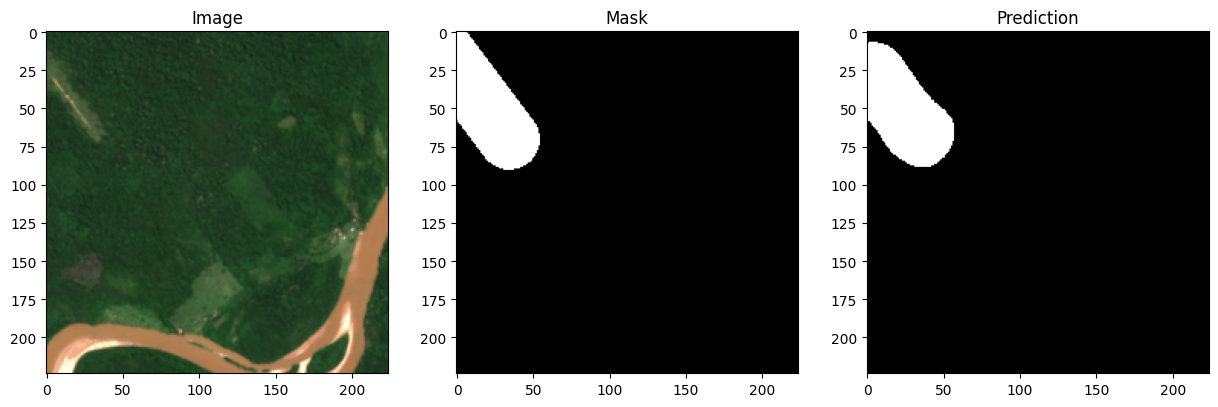

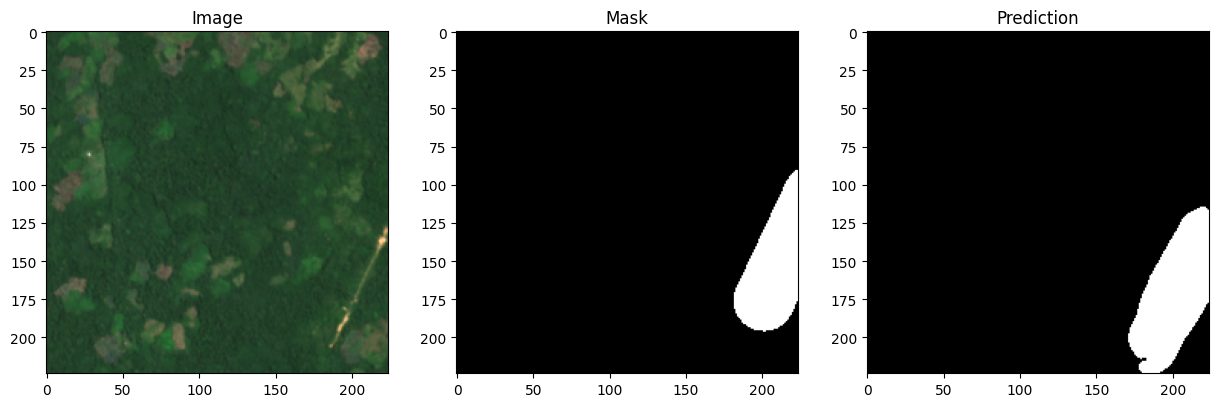

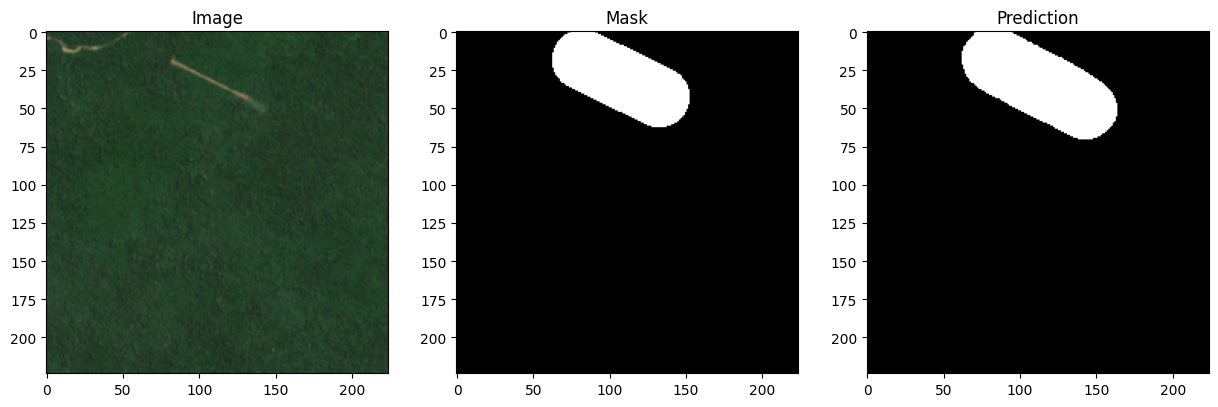

100%|██████████| 2/2 [00:09<00:00,  4.72s/it]

Test Loss: 0.53; Accuracy: 90.88
Average Jaccard Index (IoU): 0.4047


In [77]:
test_loss = evaluate(best_model, test_loader, criterion, device=device, phase="test", plot=True)

## Save Model

Let's define a function for saving the model to our local Google drive as follows.

In [78]:
model_dir = "/content/drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'zindi_best_model_20241025_200m_lr0005.pth')
model_file

'/content/drive/My Drive/Colab Notebooks/models/zindi_best_model_20241025_200m_lr0005.pth'

In [68]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [79]:
save_model(best_model, model_file)

Model successfully saved to /content/drive/My Drive/Colab Notebooks/models/zindi_best_model_20241025_200m_lr0005.pth.


In [31]:
### DON'T USE
def check_geotiffs_for_nan(images_dir):
    """Checks all GeoTIFF files in the images directory for NaN values in any band."""

    for filename in os.listdir(images_dir):
        if filename.endswith(".tif"):
            filepath = os.path.join(images_dir, filename)
            with rasterio.open(filepath) as src:
                for band_index in range(1, src.count + 1):  # Iterate over bands
                    band_data = src.read(band_index)
                    if np.isnan(band_data).any():
                        print(f"Found NaN values in {filename}, band {band_index}")
    return  # Stop after finding the first NaN value (optional)

In [32]:
images_dir = '/content/images'  # Replace with your images directory
check_geotiffs_for_nan(images_dir)

Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 1
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 2
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 3
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 4
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 5
Found NaN values in Sentinel_AllBands_Training_Id_140.tif, band 6
